In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sympy import Matrix
import time
from scipy import sparse
from copy import deepcopy

from iminuit import cost, Minuit
# faster than scipy.stats functions
from numba_stats import truncnorm, truncexpon, norm, expon
from scipy.stats import multivariate_normal as mvnorm

In [5]:
"""
Idea is to index a 2D array using some 1D curve. Thus, there is an index mapping from each (x,y)->ind
Further, each site also has an adjancency set. This is the set of indices that are coupled to the site by an FM interaction
The model is defined using a 1xN field matrix and an NxN coupling matrix. The coupling matrix is sparse. N = LxW
"""
L= 3

def index_map(x, y, L):
    if x>L or y>L: return None
    return x*L + y

def square_lattice_dictionary(L):
    
    ind_dict = {}
    adj_ind = {}
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)

            adjs = [index_map(x,(y+1)%L, L), index_map(x,(y-1)%L, L), index_map((x+1)%L,y, L), index_map((x-1)%L,y, L)]
            
            ind_dict[ind_0] = (x,y)
            adj_ind[ind_0] = adjs
    return ind_dict, adj_ind

def triangle_lattice_dictionary(L):
    ind_dict = {}
    adj_ind = {}
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)
            
            #nn indices
            adjs = [index_map(x,(y+1)%L, L), index_map(x,(y-1)%L, L), index_map((x+1)%L,y, L), index_map((x-1)%L,y, L)]
            adjs.append(index_map((x+1)%L,(y-(-1)**(x%2))%L, L))
            adjs.append(index_map((x-1)%L,(y-(-1)**(x%2))%L, L))
            
            #nnn indices
            adjs += [index_map(x,(y+2)%L, L), index_map(x,(y-2)%L, L), index_map((x+2)%L,y, L), index_map((x-2)%L,y, L)]
            adjs += [index_map((x+2)%L,(y+1)%L, L), index_map((x+2)%L,(y-1)%L, L), index_map((x-2)%L,(y+1)%L, L), index_map((x-2)%L,(y-1)%L, L)]
            adjs += [index_map((x+1)%L,(y+(-1)**(x%2))%L, L), index_map((x+1)%L,(y-2*(-1)**(x%2))%L, L)]
            adjs += [index_map((x-1)%L,(y+(-1)**(x%2))%L, L), index_map((x-1)%L,(y-2*(-1)**(x%2))%L, L)] 
            
            ind_dict[ind_0] = (x,y)
            adj_ind[ind_0] = list(set(adjs))
    return ind_dict, adj_ind

def triangle_nn_indices(L):
    adj_ind = {}
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)
            
            #nn indices
            adjs = [index_map(x,(y+1)%L, L), index_map(x,(y-1)%L, L), index_map((x+1)%L,y, L), index_map((x-1)%L,y, L)]
            adjs.append(index_map((x+1)%L,(y-(-1)**(x%2))%L, L))
            adjs.append(index_map((x-1)%L,(y-(-1)**(x%2))%L, L))

            adj_ind[ind_0] = adjs
    return adj_ind

def triangle_nnn_indices(L):
    adj_ind = {}
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)
            
            #nnn indices
            adjs = [index_map(x,(y+2)%L, L), index_map(x,(y-2)%L, L), index_map((x+2)%L,y, L), index_map((x-2)%L,y, L)]
            adjs += [index_map((x+2)%L,(y+1)%L, L), index_map((x+2)%L,(y-1)%L, L), index_map((x-2)%L,(y+1)%L, L), index_map((x-2)%L,(y-1)%L, L)]
            adjs += [index_map((x+1)%L,(y+(-1)**(x%2))%L, L), index_map((x+1)%L,(y-2*(-1)**(x%2))%L, L)]
            adjs += [index_map((x-1)%L,(y+(-1)**(x%2))%L, L), index_map((x-1)%L,(y-2*(-1)**(x%2))%L, L)] 
            
            adj_ind[ind_0] = adjs
    return adj_ind

ind_dict, adj_ind = triangle_lattice_dictionary(L)

def linear_fit(x, m, b):
    return m*x + b
def power_law(x, a):
    return x**(-a)

def power_law_scale(x, a, scale):
    return scale*x**(-a)

def exponential_dist_norm(x, a):
    return a*np.exp(-a*x)

def exponential_dist(x, A, b):
    return A*np.exp(-b*x)

In [27]:
ind_dict, adj_ind = triangle_lattice_dictionary(5)

nn_ind = triangle_nn_indices(4)
nn_ind[5]

[6, 4, 9, 1, 10, 2]

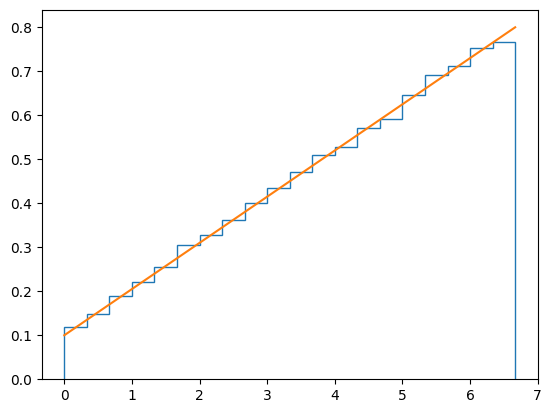

In [74]:
def random_nnDist(a,b,custDist,size=None, nControl=10**6):
    #genearte a list of size random samples, obeying the distribution custDist
    #suggests random samples between x0 and x1 and accepts the suggestion with probability custDist(x)
    #custDist noes not need to be normalized. Add this condition to increase performance. 
    #Best performance for max_{x in [x0,x1]} custDist(x) = 1
    samples=[]
    nLoop=0
    
    low = 0
    high = (np.sqrt(a**2 + 6*b) - a)/b
    
    while len(samples)<size and nLoop<nControl:
        x=np.random.uniform(low=low,high=high)
        prop=custDist(x, a, b)
        assert prop>=0 and prop<=1
        if np.random.uniform(low=0,high=1) <=prop:
            samples += [x]
        nLoop+=1
    return samples

def random_nnnDist(a,b,custDist,size=None, nControl=10**6):
    samples=[]
    nLoop=0
    
    low = (np.sqrt(a**2 + 6*b) - a)/b
    high = (np.sqrt(a**2 + 2*b*(9+a*low+b*low**2/2))-a)/b
    
    while len(samples)<size and nLoop<nControl:
        x=np.random.uniform(low=low,high=high)
        prop=custDist(x, a, b)
        assert prop>=0 and prop<=1
        if np.random.uniform(low=0,high=1) <=prop:
            samples += [x]
        nLoop+=1
    return samples


#call
a=0.1
b=0.105

def linDist(x, a, b):
    return (a + b*x)

def linDist_nn(x, a, b):
    return (a + b*x)/3.0

def linDist_nnn(x, a, b):
    return (a + b*x)/9.0

w = (np.sqrt(a**2 + 6*b) - a)/b
samples=random_nnDist(a,b,custDist=linDist_nn,size=100000)
#print(samples)

n, bins = np.histogram(np.array(samples), density=True, bins = 20)
plt.stairs(3*n, bins)

x = np.linspace(0, w, 1000)
plt.plot(x, 3*np.array(linDist_nn(x, a, b)))

#samples=random_nnnDist(w,a,b,custDist=linDist,size=100000)
#plt.hist(np.array(samples), density=True, bins = 20)

#x = np.linspace(0, (np.sqrt(a**2 + 2*b) - a)/b, 1000)
#plt.plot(x, np.array(linDist(x, a, b)))


In [83]:
from scipy import integrate

integrate.quad(lambda x:linDist_nn(x, a, b), 0, w)

(1.0000000000000002, 1.1102230246251569e-14)

In [7]:
def update_adjacency_J_ij(adj_ind, i, j):
    #Updates adjaceny set of i with that of j
    #Also deletes index from the adjacency list of other indices
    temp_adj = adj_ind
    adj_i = adj_ind[i]
    adj_j = adj_ind[j]
     
    adj_i_new = list(set(adj_i+adj_j))
    adj_i_new = list(set(adj_i_new)-set([i, j]))
    temp_adj[i] = adj_i_new
    temp_adj[j] = []
    
    for k in adj_i_new:
        temp_adj[k] = list(set(adj_ind[k]+[i])-set([j]))
        
    return temp_adj

def update_adjacency_h(adj_ind, i):
    #Updates adjacency set of every element in adj(i) with adj(i)
    #Also deletes index i from adj(k) for all k in adj(i)
    temp_adj = adj_ind
    adj_i = adj_ind[i]
    
    for k in adj_ind[i]:
        temp_adj[k] = list(set(adj_ind[k]+adj_i)-set([i]))
        
    temp_adj[i] = []
    return temp_adj
    

In [8]:
class system:
    
    def __init__(self, size, adj_ind, J_sys, h_sys):
        
        self.size = size
        self.adj_ind = adj_ind
        self.J_ij_vals = J_sys
        self.h_vals = h_sys
        self.cluster_tracker = np.ones(size)
        self.cluster_ind = np.arange(size)
        
        self.Gamma_array = []
        self.Omega_0 = max(self.h_vals.max(), self.J_ij_vals.max())
        self.Omega = self.Omega_0
        return None
    
    def decimate(self):
        Omega = max(self.h_vals.max(), self.J_ij_vals.max())
        self.Omega = Omega
        self.Gamma_array.append(np.log(self.Omega_0/Omega))
        if Omega == self.J_ij_vals.max(): self.J_decimation(Omega)
        elif Omega == self.h_vals.max(): self.h_decimation(Omega)
        
        return None
    
    def J_decimation(self, Omega):
        r_ind, c_ind, J_ij = sparse.find(self.J_ij_vals) 
        J_ind = np.where(J_ij == Omega)[0][0]
        i, j = r_ind[J_ind], c_ind[J_ind]

        self.h_vals[i] = self.h_vals[i]*self.h_vals[j]/Omega    
        self.h_vals[j] = 0

        self.adj_ind = update_adjacency_J_ij(self.adj_ind, i, j)

        self.J_ij_vals[i,self.adj_ind[i]] = self.J_ij_vals[i, self.adj_ind[i]].maximum(self.J_ij_vals[j, self.adj_ind[i]])
        self.J_ij_vals[self.adj_ind[i], i] = self.J_ij_vals[i,self.adj_ind[i]]

        eye = chunk_deleter([j], self.size)
        self.J_ij_vals = eye @ self.J_ij_vals @ eye
        
        
        self.cluster_tracker[i] += self.cluster_tracker[j]
        self.cluster_tracker[j] = 0
        
        self.cluster_ind[j] = self.cluster_ind[i]
        return None
    
    def h_decimation(self, Omega):
        i = np.where(self.h_vals == self.h_vals.max())[0][0]
        adj_i = self.adj_ind[i]
        J_ij_new = self.J_ij_vals.tocsr()[adj_i, i] @self.J_ij_vals.tocsc()[i, adj_i]/Omega
        
        #Sparsify the matrix, introduce cutoff
        J_ij_new.data[J_ij_new.data<self.Omega_0/2]=0

        self.J_ij_vals[adj_i, :][:, adj_i] = J_ij_new.maximum(self.J_ij_vals[adj_i,:][:, adj_i])

        self.h_vals[i] = 0

        eye = chunk_deleter([i], self.size)
        
        #J_ij_vals[i,:] = 0
        #J_ij_vals[:,i] = 0
        self.J_ij_vals = eye @ self.J_ij_vals @ eye

        self.adj_ind = update_adjacency_h(self.adj_ind, i)
        return None
        

In [43]:
#Main

L = 40
steps = 1500
runs = 1
measure_step = 20

nn_ind = triangle_nn_indices(L)
nnn_ind = triangle_nnn_indices(L)

a,b =  0.3, 0.305

J_ij_vals = fill_J_ij_matrix(L*L, nn_ind, nnn_ind, a, b)
h_vals = np.exp(-np.random.exponential(size=L*L))

#J_ij_vals = J_temp
#h_vals = h_temp
J1, h1 = deepcopy(J_ij_vals), deepcopy(h_vals)

R0_array_copy = []
ind_dict, adj_ind = triangle_lattice_dictionary(L)
test = system(L*L, adj_ind, J1, h1)
t0 = time.time()
moment_array = []
for step in range(steps):
    
    test.decimate()
    if step%measure_step == 0:
        R0_array_copy.append(extract_width(test.h_vals, test.Omega))
        moment_array.append(test.cluster_tracker[test.cluster_tracker!=0].mean())

print(time.time()-t0)

/home/jebediah/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


43.73896551132202


In [81]:
J_ij_vals = fill_J_ij_matrix(L*L, nn_ind, nnn_ind, a, b).tocoo()
h_vals = np.exp(-np.random.exponential(size=L*L))


0.999934184543264

In [82]:
#Legacy code
R0_array_sum = np.zeros(int(np.ceil(steps/measure_step)))

cluster_tracker = np.ones(L*L)

a_vals = np.array([0.1])#np.arange(0.05, 0.2, 0.02)
b_vals = np.array([0.105])#np.arange(0.1,0.3,0.03)


for run in range(runs):
    Gamma_array = np.zeros(shape=(len(a_vals), len(b_vals), steps))
    R0_array = []
    mu_array = []
    color_list = []
    color_list_m = []
    #R0_array_err = []

    t_total_Jij = 0
    t_total_h = 0

    for l, a in enumerate(a_vals):
        for m, b in enumerate(b_vals):

            ind_dict, adj_ind = triangle_lattice_dictionary(L)

            #J_ij_vals = fill_J_ij_matrix(L*L, nn_ind, nnn_ind, a, b)
            #h_vals = np.exp(-np.random.exponential(size=L*L))
            
            #J_temp = J_ij_vals
            #h_temp = h_vals
            
            Omega_0 = max(h_vals.max(), J_ij_vals.max())
            t0 = time.time()
            for step in range(steps):
                
                if step%1000 == 0: print ("Step: "+str(step)+"/"+str(steps))
                Omega = max(h_vals.max(), J_ij_vals.max())
                
                Gamma_array[l,m,step] = (np.log(Omega_0/Omega))
                #J_ij_vals = resparse(J_ij_vals, L*L, Omega*(1-steps/(L*L)))

                if Omega == J_ij_vals.max():
                    """
                    Strongest term is an Ising coupling -> Renormalizes to a field given by h_i * h_j/J_ij
                    Delete one of the elements (say h_i), shortening h_vals
                    Update adjacency of j to include both adj(i) and adj(j)
                    Set new Jnew_jk = max (J_jk, J_ik)
                    Delete the corresponding row and column in J_ij (J_i* and J*i) and set the adjacency of i to []
                    """
                    r_ind, c_ind, J_ij = sparse.find(J_ij_vals) 
                    J_ind = np.where(J_ij == Omega)[0][0]
                    i, j = r_ind[J_ind], c_ind[J_ind]

                    h_vals[i] = h_vals[i]*h_vals[j]/Omega    #Might need to include a factor of 2 here since we are symmetrizing later
                    h_vals[j] = 0

                    adj_ind = update_adjacency_J_ij(adj_ind, i, j)
                    
                    J_csr = J_ij_vals.tocsr()
                    J_csc = J_ij_vals.tocsc()
                    
                    J_csc[i,adj_ind[i]] = J_csc[i, adj_ind[i]].maximum(J_csc[j, adj_ind[i]])
                    J_csr[adj_ind[i], i] = J_csc[i,adj_ind[i]]

                    eye = chunk_deleter([j], L*L)
                    J_ij_vals = eye @ J_ij_vals @ eye
                    t_total_Jij += time.time()-t0
                    cluster_tracker[i] += cluster_tracker[j]
                    cluster_tracker[j] = 0
                    color_list.append('blue')
                elif Omega == h_vals.max():
                    """
                    """
                    #t0 = time.time()
                    i = np.where(h_vals == h_vals.max())[0][0]
                    adj_i = adj_ind[i]
                    
                    J_csr = J_ij_vals.tocsr()
                    J_csc = J_ij_vals.tocsc()
                    
                    J_ij_new = J_csr[adj_i, i] @J_csc[i, adj_i]/Omega

                    J_ij_vals[adj_i, :][:, adj_i] = J_ij_new.maximum(J_ij_vals[adj_i,:][:, adj_i])

                    h_vals[i] = 0

                    eye = chunk_deleter([i], L*L)
                    J_ij_vals = eye @ J_ij_vals @ eye

                    adj_ind = update_adjacency_h(adj_ind, i)
                    t_total_h += time.time()-t0
                    color_list.append('red')
                if step%measure_step == 0:
                    h_remain = h_vals[h_vals!=0]
                    cluster_moments = cluster_tracker[cluster_tracker!=0]
                    cost_func = cost.UnbinnedNLL(-np.log(h_remain/Omega), exponential_dist_norm)
                    fit_obj = Minuit(cost_func, a=0.8)
                    fit_obj.limits["a"] = (0, 4)
                    fit_obj.migrad()
                    color_list_m.append(color_list[-1])
                    R0_array.append(fit_obj.values[0])
                    mu_array.append(cluster_moments.mean())
                    
                    #R0_array_err.append(pcov[0][0])
    #R0_array_sum += np.array(R0_array)
    
print(time.time()-t0)


Step: 0/1500


/home/jebediah/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/jebediah/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Step: 1000/1500
23.282835006713867


In [ ]:
steps = 700
check_list = np.array([0, 300, 600])

for i in range(steps):
    test.decimate()
    if i in check_list:
        h_remain = test.h_vals
        h_remain = h_remain[h_remain!=0]
        n,bins = np.histogram(-np.log(h_remain/test.Omega), density=True, bins = 50)
        width = bins[1]-bins[0]
        plt.scatter(bins[1:]-width/2, n)

#plt.xscale('log')
plt.yscale('log')

In [8]:
from scipy import sparse
L = 4
ind_dict, adj_ind = square_lattice_dictionary(L)
a, b = (0.1, 0.1)

In [80]:
def fill_J_ij_matrix(size, nn_ind, nnn_ind, a, b, include_nnn=True):
    J_ij_vals = sparse.lil_matrix((size, size))
    bond_sum = 0
    #hit_mat = np.zeros(shape=(size, size))
    for ind in range(size):
        
        #Filling nn bonds
        adj_ind_array = np.array(nn_ind[ind])
        upper_ind = adj_ind_array[adj_ind_array>ind]
        bond_sum+=len(upper_ind)
        #print(ind, upper_ind)
        #hit_mat[ind, upper_ind] = 1
        #Include jacobian to transform pdf
        J_ij_vals[ind, upper_ind] = sparse.lil_matrix(np.exp(-np.array(random_nnDist(a, b, custDist=linDist, size=len(upper_ind)))))
        
        if include_nnn:
            #Filling nnn bonds
            adj_ind_array = np.array(nnn_ind[ind])
            upper_ind = adj_ind_array[adj_ind_array>ind]

            J_ij_vals[ind, upper_ind] = sparse.lil_matrix(np.exp(-np.array(random_nnnDist(a, b, custDist=linDist_nnn, size=len(upper_ind)))))
    #plt.imshow(hit_mat + hit_mat.T)
    print(bond_sum)
    return J_ij_vals + J_ij_vals.T

def chunk_deleter(ind_array, size):
    eye_diag = np.ones(size)
    eye_diag[ind_array] = 0
    return sparse.diags(eye_diag)

def resparse(spr_mat, size, tol):
    i_ind, j_ind, vals = sparse.find(spr_mat)
    mask = vals>tol
    i_new, j_new, val_new = i_ind[mask], j_ind[mask], vals[mask]
    
    return sparse.csr_matrix((val_new, (i_new, j_new)), shape=(size, size))

In [30]:
def fill_J_ij_matrix_uniform(size, nn_ind, J_max, include_nnn=False):
    J_ij_vals = sparse.lil_matrix((size, size))
    for ind in range(size):
        
        #Filling nn bonds
        adj_ind_array = np.array(nn_ind[ind])
        upper_ind = adj_ind_array[adj_ind_array>ind]
        
        
        J_ij_vals[ind, upper_ind] = sparse.lil_matrix(np.random.uniform(0, log_J_max, size=len(upper_ind)))
        
        if include_nnn:
            #Filling nnn bonds
            w = (np.sqrt((a/3)**2 + 2*(b/3)) - a/3)/(b/3)
            adj_ind_array = np.array(nnn_ind[ind])
            upper_ind = adj_ind_array[adj_ind_array>ind]

            J_ij_vals[ind, upper_ind] = sparse.lil_matrix(np.exp(-np.array(random_nnnDist(w, a/6.0, b/6.0, custDist=linDist, size=len(upper_ind)))))

    return J_ij_vals + J_ij_vals.T

30000


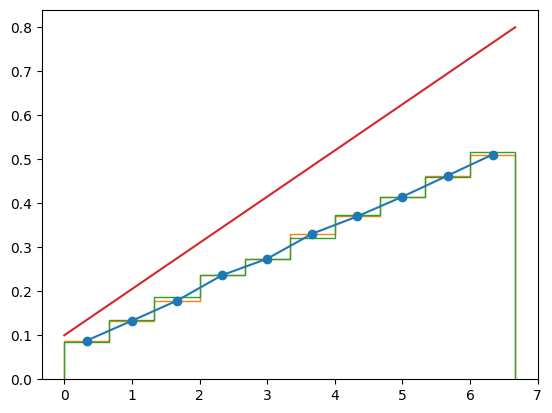

In [84]:
L=100
nn_ind = triangle_nn_indices(L)
nnn_ind = triangle_nnn_indices(L)
a,b=  0.1, 0.105

J_ij_vals = fill_J_ij_matrix(L*L, nn_ind, nnn_ind, a, b, include_nnn=False)


sparse.find(J_vals)[2]

J_remain = sparse.find(J_ij_vals)[2]

n, bins = np.histogram(-np.log(J_remain))
plt.figure()
width = bins[1]-bins[0]
plt.plot(bins[1:]-width/2, n/(2*L*L), marker='o')

plt.stairs(n/(2*L*L), bins)
#plt.ylim(0, 0.6)

samples=random_nnDist(a,b,custDist=linDist_nn,size=30000)
#print(samples)

n,bins = np.histogram(np.array(samples))
plt.stairs(n/(L*L), bins)
plt.plot(x, 3*np.array(linDist_nn(x, a, b)))

5.0

(0.0, 0.6)

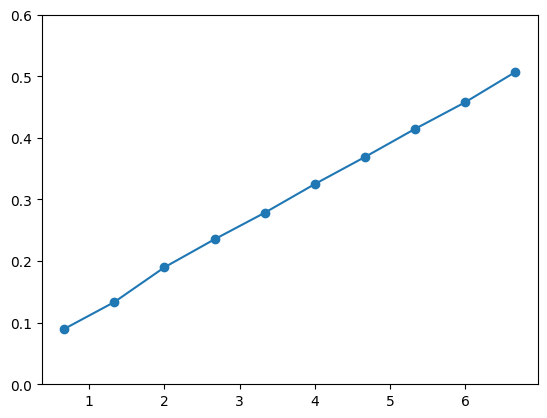

In [23]:
L, J_max = 100, 1
nn_ind = triangle_nn_indices(L)
nnn_ind = triangle_nnn_indices(L)
a,b=  0.1, 0.105
#nnn_ind = triangle_nnn_indices(L)
#t = time.time()
#J_ij_vals = fill_J_ij_matrix_uniform(L*L, nn_ind, J_max)
J_ij_vals = fill_J_ij_matrix(L*L, nn_ind, nnn_ind, a, b, include_nnn=False)

J_remain = sparse.find(J_ij_vals)[2]

n, bins = np.histogram(-np.log(J_remain))

plt.plot(bins[1:], n/(2*L*L), marker='o')
plt.ylim(0, 0.6)

In [ ]:


#fill_J_ij_matrix(L, adj_ind, a, b)
L, a, b = 100, 0.1, 0.1
nn_ind = triangle_nn_indices(L)
nnn_ind = triangle_nnn_indices(L)
t = time.time()
J_ij_vals = fill_J_ij_matrix(L*L, nn_ind, nnn_ind, a, b, include_nnn=True)
print(-t+time.time())

In [ ]:
a_sc = a/9
b_sc = b/9
J_remain = -np.log(sparse.find(J_ij_vals)[2])
x = np.linspace(0, (np.sqrt(a_sc**2 + 2*b_sc) - a_sc)/b_sc, len(J_remain))

n,bins,patches = plt.hist(J_remain, density = 'True', bins=30)
width = bins[1]-bins[0]
popt, pcov = curve_fit(linDist, (bins[1:]-width/2), n)

plt.plot(x, np.array(linDist(x, *popt)))
print(popt)

In [38]:
def extract_width(hs, Om):
    h_left = hs[hs!=0]
    c = cost.UnbinnedNLL(-np.log(h_left/Om), exponential_dist_norm)
    m = Minuit(c, a=0.8)
    m.migrad()
    return m.values[0]

In [ ]:
n_array = (- np.arange(steps)+(L*L))/(L*L)
plt.figure(figsize=(9, 6))
for l, a in enumerate(a_vals):
    for m, b in enumerate(b_vals):
        plt.scatter(Gamma_array[l,m,:],  n_array, s=10, label="("+str(a)+', '+str(b)+")")
plt.plot(Gamma_array[0,0,:], (Gamma_array[0,0,:]+1)**(-1.368))



plt.legend()
#plt.xlim(0, 10)

In [47]:
#Main

L = 60
steps = 3500
runs = 1
measure_step =50

nn_ind = triangle_nn_indices(L)
nnn_ind = triangle_nnn_indices(L)

a,b =  0.3, 0.315

J_ij_vals = fill_J_ij_matrix(L*L, nn_ind, nnn_ind, a, b, include_nnn=False)
h_vals = np.exp(-np.random.exponential(size=L*L))

#J_ij_vals = J_temp
#h_vals = h_temp
J1, h1 = deepcopy(J_ij_vals), deepcopy(h_vals)

R0_array_copy = []
ind_dict, adj_ind = triangle_lattice_dictionary(L)
test = system(L*L, adj_ind, J1, h1)
t0 = time.time()
moment_array = []
for step in range(steps):
    
    test.decimate()
    if step%measure_step == 0:
        R0_array_copy.append(extract_width(test.h_vals, test.Omega))
        moment_array.append(test.cluster_tracker[test.cluster_tracker!=0].mean())

print(time.time()-t0)

408.4865462779999


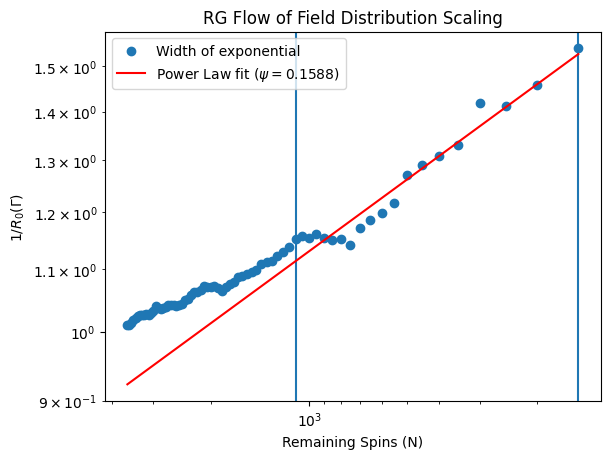

In [50]:

x = L*L - np.arange(len(R0_array_copy))*measure_step
y = runs/np.array(R0_array_copy)
#R_length = len(y)

start = -20#70
end = -1

plt.axvline(x = x[start])
plt.axvline(x = x[end])
plt.scatter(x, y, label='Width of exponential')#, c=color_list_m)#, yerr=np.sqrt(np.array(R0_array_err))/np.array(R0_array)**2)
#plt.yscale('log')

popt, pcov = curve_fit(power_law_scale, x[start:end], y[start:end])

#y_copy = runs/np.array(R0_array_copy)
#plt.scatter(x, y_copy)

#plt.text(x=L*L, y=1.5, s=("a="+str(a_vals[0])+'\n' +"b="+str(b_vals[0])+"\n"+"N="+str(L*L)))

plt.title("RG Flow of Field Distribution Scaling")
plt.xlabel("Remaining Spins (N)")
plt.ylabel(r"$1/R_0(\Gamma)$")
plt.plot(x, power_law_scale(x, *popt), color='red', label=r'Power Law fit ($\psi=$'+str(round(popt[0], 4))+')')

plt.gca().invert_xaxis()
plt.legend()
plt.yscale('log')
plt.xscale('log')

#plt.xlim(1e4, 0.8*1e3)
#plt.ylim(1, 2)

In [ ]:
x_array = np.arange(L)
ZZ_corr = np.zeros(shape=(L))

x_0, y_0 = (0,1)


for x in range(L):
    if test.cluster_ind[index_map(x_0, y_0, L)] == test.cluster_ind[index_map(x, y_0,L)]: ZZ_corr[x] = 1

In [ ]:
plt.scatter(x_array, ZZ_corr)

In [ ]:
y = np.array(moment_array)

plt.scatter(x, y)

start = -10
end = -1

plt.axvline(x = x[start])
plt.axvline(x = x[end])
popt, pcov = curve_fit(power_law_scale, x[start:end], y[start:end])

plt.plot(x, power_law_scale(x, *popt), color='red', label=r'Power Law fit ($\psi=$'+str(round(popt[0], 4))+')')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.gca().invert_xaxis()

In [ ]:
check_list = np.floor(L*L*(1- 1/(2.5**np.arange(len(x)))))
print

In [ ]:
log_x = np.log(x)
log_mu = np.log(np.array(mu_array))

plt.scatter(np.exp(log_x), np.exp(log_mu))
plt.gca().invert_xaxis()

popt, pcov = curve_fit(linear_fit,log_x , log_mu)

plt.plot(np.exp(log_x), np.exp(linear_fit(log_x, *popt)))
#plt.xscale('log')
#plt.yscale('log')
print(popt)

In [ ]:
popt, pcov = curve_fit(power_law_scale, x[-150:], 1/np.array(R0_array)[-150:])
print(popt)
print(popt[0]*2)

In [ ]:
print(t_total_Jij)
print(t_total_h)

In [ ]:
popt, pcov = curve_fit(power_law, Gamma_array[0,0,:]+1, n_array)
popt

In [ ]:
h_vals_remain = h_vals[h_vals!=0]
plt.figure(figsize=(8,5))
n,bins, pacthes = plt.hist(-np.log(h_vals_remain), density=True, bins = 30)

width = bins[1]-bins[0]

plt.figure(figsize=(8,5))
x_data = bins[1:]-width/2
popt, pcov = curve_fit(exponential_dist,x_data, n)

plt.plot(x_data, exponential_dist(x_data, *popt), label='Fit to exponential distribution')
plt.scatter(x_data, n)
plt.title("Distribution of Field Couplings after Decimation")
plt.yscale('log')
plt.legend()
print(popt)

In [ ]:
h_vals_ini = np.exp(-np.random.exponential(size=L*L))
n,bins, pacthes = plt.hist(-np.log(h_vals_ini), density=True, bins = 30)

width = bins[1]-bins[0]


x_data = bins[1:]-width/2
popt, pcov = curve_fit(exponential_dist,x_data, n)

plt.plot(x_data, exponential_dist(x_data, *popt), label='Fit to exponential distribution')
plt.title("Initial Distributions of Field Couplings")
plt.legend()

In [ ]:
def triangle_lattice_boundary_dictionary(L):
    ind_dict = {}
    adj_ind = {}
    bdry_dict = np.zeros(L*L,dtype=bool)
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)
            
            #nn indices
            adjs = [index_map(x,(y-1)%L, L), index_map(x,(y+1)%L, L)]
            
            adjs += [index_map(x,(y+2)%L, L), index_map(x,(y-2)%L, L)]
            
            if x-1>=0:
                adjs.append(index_map((x-1)%L,y, L))
                adjs.append(index_map((x-1)%L,(y-(-1)**(x%2))%L, L))
                
                adjs += [index_map((x-1)%L,(y+(-1)**(x%2))%L, L), index_map((x-1)%L,(y-2*(-1)**(x%2))%L, L)]
            if x+1<L:
                adjs.append(index_map((x+1)%L,y, L))
                adjs.append(index_map((x+1)%L,(y-(-1)**(x%2))%L, L))
                
                adjs += [index_map((x+1)%L,(y+(-1)**(x%2))%L, L), index_map((x+1)%L,(y-2*(-1)**(x%2))%L, L)]
            
            if x-2>=0:
                adjs += [index_map((x-2)%L,y, L), index_map((x-2)%L,(y+1)%L, L), index_map((x-2)%L,(y-1)%L, L)]
            if x+2<L:
                adjs += [index_map((x+2)%L,y, L), index_map((x+2)%L,(y+1)%L, L), index_map((x+2)%L,(y-1)%L, L)]
            
            if x==0: bdry_dict[ind_0] = True
            elif x==(L-1): bdry_dict[ind_0] = True      
                
            ind_dict[ind_0] = (x,y)
            adj_ind[ind_0] = adjs
    return ind_dict, adj_ind, bdry_dict

In [ ]:
class boundary_system:
    
    def __init__(self, size, adj_ind, bdry_dict, J_ij_vals, h_vals):
        
        self.size = size
        self.adj_ind = adj_ind
        self.J_ij_vals = J_ij_vals
        self.h_vals = h_vals
        self.bdry_dict = bdry_dict
        
        self.Gamma_array = []
        self.Omega_0 = max(h_vals.max(), J_ij_vals.max())
        self.Omega = self.Omega_0
        return None
    
    def decimate(self):
        Omega = max(self.h_vals.max(), self.J_ij_vals.max())
        self.Omega = Omega
        self.Gamma_array.append(np.log(self.Omega_0/Omega))
        if Omega == self.J_ij_vals.max(): self.J_decimation(Omega)
        elif Omega == self.h_vals.max(): self.h_decimation(Omega)
        
        return None
    def J_decimation(self, Omega):
        r_ind, c_ind, J_ij = sparse.find(self.J_ij_vals) 
        J_ind = np.where(J_ij == Omega)[0][0]
        i, j = r_ind[J_ind], c_ind[J_ind]

        self.h_vals[i] = self.h_vals[i]*self.h_vals[j]/Omega    
        self.h_vals[j] = 0
        self.bdry_dict[i] = self.bdry_dict[i] or self.bdry_dict[j]
        self.bdry_dict[j] = False
        
        update_adjacency_J_ij(self.adj_ind, i, j)

        self.J_ij_vals[i,self.adj_ind[i]] = self.J_ij_vals[i, self.adj_ind[i]].maximum(self.J_ij_vals[j, self.adj_ind[i]])
        self.J_ij_vals[self.adj_ind[i], i] = self.J_ij_vals[i,self.adj_ind[i]]

        eye = chunk_deleter([j], self.size)
        self.J_ij_vals = eye @ self.J_ij_vals @ eye
        return None
    
    def h_decimation(self, Omega):
        i = np.where(self.h_vals == self.h_vals.max())[0][0]
        adj_i = self.adj_ind[i]
        J_ij_new = self.J_ij_vals[adj_i, i] @self.J_ij_vals[i, adj_i]/Omega

        self.J_ij_vals[adj_i, :][:, adj_i] = J_ij_new.maximum(self.J_ij_vals[adj_i,:][:, adj_i])

        self.h_vals[i] = 0

        eye = chunk_deleter([i], self.size)
        self.J_ij_vals = eye @ self.J_ij_vals @ eye

        update_adjacency_h(self.adj_ind, i)
        return None

In [ ]:
L = 50
steps = 2400#int(0.95*L*L)
a, b = 0.1, 0.105
measure_step = 20

ind_dict, adj_ind, bdry_dict = triangle_lattice_boundary_dictionary(L)
nn_ind = triangle_nn_indices(L)
nnn_ind = triangle_nnn_indices(L)

check_list = np.floor(L*L*(1- 1/(2.5**np.arange(10))))

runs = 1

In [ ]:
for run in range(runs):  
    J_ij_vals = fill_J_ij_matrix(L*L, nn_ind, nnn_ind, a, b)
    h_vals = np.exp(-np.random.exponential(size=L*L))
    test = boundary_system(L*L, adj_ind, bdry_dict, J_ij_vals, h_vals)

    
    R0_array_bulk = np.zeros(int(steps/measure_step)+1)
    R0_array_bdry = np.zeros(int(steps/measure_step)+1)

    for i in range(steps):
        test.decimate()
        if i%measure_step==0:
            h_remain_bulk = test.h_vals[~bdry_dict]
            h_remain_bulk = h_remain_bulk[h_remain_bulk!=0]
            cost_func = cost.UnbinnedNLL(-np.log(h_remain_bulk/test.Omega), exponential_dist_norm)
            fit_obj = Minuit(cost_func, a=0.8)
            #fit_obj.limits["a"] = (0, 4)
            fit_obj.migrad()
            #color_list_m.append(color_list[-1])
            R0_array_bulk[int(i/measure_step)] += fit_obj.values[0]
            
            h_remain_bdry = test.h_vals[bdry_dict]
            h_remain_bdry = h_remain_bdry[h_remain_bdry!=0]
            cost_func = cost.UnbinnedNLL(-np.log(h_remain_bdry/test.Omega), exponential_dist_norm)
            fit_obj = Minuit(cost_func, a=0.8)
            #fit_obj.limits["a"] = (0, 4)
            fit_obj.migrad()
            #color_list_m.append(color_list[-1])
            R0_array_bdry[int(i/measure_step)] += fit_obj.values[0]

In [ ]:
x = L*L - np.arange(len(R0_array_bulk))*measure_step
y_bulk = runs/R0_array_bulk
y_bdry = runs/R0_array_bdry
R_length = len(y_bulk)

start = 50
end = -10

plt.axvline(x = x[start])
plt.axvline(x = x[end])
plt.scatter(x, y_bulk, label='Width of exponential')#, yerr=np.sqrt(np.array(R0_array_err))/np.array(R0_array)**2)

plt.scatter(x, y_bdry)
#plt.yscale('log')

popt, pcov = curve_fit(power_law_scale, x[start:end], y_bulk[start:end])

plt.title("RG Flow of Field Distribution Scaling")
plt.xlabel("Remaining Spins (N)")
plt.ylabel(r"$1/R_0(\Gamma)$")
plt.plot(x, power_law_scale(x, *popt), color='red', label=r'Bulk power Law fit ($\psi=$'+str(round(popt[0], 4))+')')

start = 50
end = -10
popt, pcov = curve_fit(power_law_scale, x[start:end], y_bdry[start:end])
plt.plot(x, power_law_scale(x, *popt), c='green',label=r'Bdry power Law fit ($\psi=$'+str(round(popt[0], 4))+')')

plt.gca().invert_xaxis()
plt.legend()
plt.yscale('log')
plt.xscale('log')

In [ ]:
L = 5
steps = 24
runs = 1
measure_step = 10
a,b =  0.1, 0.105

nn_ind = triangle_nn_indices(L)
nnn_ind = triangle_nnn_indices(L)

J_prime = fill_J_ij_matrix(L*L, nn_ind, nnn_ind, a, b)
h_prime = np.exp(-np.random.exponential(size=L*L))

ind_dict, adj_ind = triangle_lattice_dictionary(L)

h_prime

In [ ]:
from copy import deepcopy
R0_array_1 = []

J1, h1 = deepcopy(J_prime), deepcopy(h_prime)
test = system(L*L, adj_ind, J1, h1)
for step in range(steps):
    
    test.decimate()
    if step%measure_step == 0:
        R0_array_1.append(extract_width(test.h_vals, test.Omega))
deepcopy(h_prime), deepcopy(J_ij_vals)

In [ ]:
L = 4
ind_dict, adj_ind = triangle_lattice_dictionary(L)

cluster_ind = [i for i in range(L*L)]

In [ ]:
cluster_list

In [ ]:
cluster_dict[1] = cluster_dict[0]

In [ ]:
cluster_dict